
# Mobile Plan Comparison

The goal of this project is to determine which of two mobile plans brings more profit to a telecom company, in order to aid with future marketing choices.

The dataset includes information about usage of mobile plans in 2018, including location of user, plan name, number and total length of calls, and others. On the basis of this information, conclusions must be made about the profitability of the two plans.

Amongst other conclusions from a more general analysis, the company has requested statistically-founded answers to the following two questions:

1. Does the average profit of the two plans, "Smart" and "Ultra", differ?
2. Does the average profit from users located in Moscow differ from that from users located in other regions?



## Содержание
<a id='Содержание'></a>

[Предотработка](#Предотработка)

[Подсчёты](#Подсчёты)

[Анализ данных](#Анализ_данных)
- [Минуты](#Минуты)
- [Сообщения](#Сообщения)
- [Объём интернет трафики](#Объём_интернет_трафики)

[Гипотезы и анализ](#Гипотезы_и_анализ)

[Общие Выводы](#Общие_Выводы)



In [1]:
import pandas as pd
import re
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st



In [2]:
try:
    users = pd.read_csv('datasets/users.csv')
    tariff_info = pd.read_csv('datasets/tariffs.csv')
    calls = pd.read_csv('datasets/calls.csv')
    messages = pd.read_csv('datasets/messages.csv')
    internet = pd.read_csv('datasets/internet.csv')

except FileNotFoundError as e:
    print(e)
    users = pd.read_csv('/datasets/users.csv')
    tariff_info = pd.read_csv('/datasets/tariffs.csv')
    calls = pd.read_csv('/datasets/calls.csv')
    messages = pd.read_csv('/datasets/messages.csv')
    internet = pd.read_csv('/datasets/internet.csv')


[display(df.head()) for df in [users, tariff_info, calls, messages, internet]]

[print(df.info(), '\n\n') for df in [users, tariff_info, calls, messages, internet]]


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 n

[None, None, None, None, None]

## Предотработка
<a id='Предотработка'></a>

[Содержание](#Содержание)

**Предотработка: изменение типа данных**

Нужно изменить тип данных в следующих столбцах:
(нынешний тип > нужный тип)

users:

- churn_date: object > datetime
    - в этом столбце крайне мало информации
- reg_date: object > datetime

tariffs:

- всё в правильной форме

calls:

- id: object > int64
- call_date: object > datetime

messages:

- id: object > int64
- message_date: object > datetime

internet:

- id: object > int64
- session_date: object > datetime


В целом, есть одни и те же проблемы во всех таблицах: надо переписать id как целочисленное значение а информацию о дате как объект datetime.

Дело в том, что в столбцах id есть и user_id и id звонка/сообщения/сессии. Однако, это совсем не нужно - есть информация о user_id в столбце user_id. Нужно сначала избавиться от такого префикса, а потом переписать значения как int64.


Исправим сначала значения в столбцах id.

Удаленим префикс с user_id в значениях id.


In [3]:
pattern = re.compile(r'[0-9]{4}_')
calls['id'] = [re.sub(pattern, '', idn) for idn in calls['id']]
messages['id'] = [re.sub(pattern, '', idn) for idn in messages['id']]
internet['id'] = [re.sub(pattern, '', idn) for idn in internet['id']]


Перепишем значения в id в правильной форме.

In [5]:
calls['id'] = calls['id'].astype('int64')
messages['id'] = messages['id'].astype('int64')
internet['id'] = internet['id'].astype('int64')

calls.info()
messages.info()
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  int64  
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 6.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  int64 
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unna

Перепишем информацию о дате как объекты datetime

In [6]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d').dt.month
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d').dt.month
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d').dt.month
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d').dt.month
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d').dt.month


Проверка типов данных

In [7]:
[df.info() for df in [users, calls, messages, internet]]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   user_id     500 non-null    int64  
 1   age         500 non-null    int64  
 2   churn_date  38 non-null     float64
 3   city        500 non-null    object 
 4   first_name  500 non-null    object 
 5   last_name   500 non-null    object 
 6   reg_date    500 non-null    int64  
 7   tariff      500 non-null    object 
dtypes: float64(1), int64(3), object(4)
memory usage: 31.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  int64  
 1   call_date  202607 non-null  int64  
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 6.2 MB
<class 'pandas.co

[None, None, None, None]

Проверка за явные дубликаты

In [8]:
[display(df[df.duplicated() == True]) for df in [users, calls, messages, internet]]


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff


,id,call_date,duration,user_id


,id,message_date,user_id


,Unnamed: 0,id,mb_used,session_date,user_id


[None, None, None, None]

In [9]:
calls['duration'] = [math.ceil(dur) for dur in calls['duration'] if dur == dur]

In [10]:
internet['gb_used'] = [mb/1024 for mb in internet['mb_used']]

**Предотработка: итоги**

Данные были получены в очень чистом, правильном виде. Не было дубликатов, и единственный столбец с пропусками - churn_date в таблице users. В этом столбце очень мало значений; это значит, что продавляющее большинство пользователей ещё являются клиентами, а поэтому у них нет churn_date, то есть их тариф ещё действовал на момент выгрузки данных.

Пришлось изменить тип данных object (что здесь означает str) или на целочисленное значение (int64) или на объект datetime, в зависимости от столбца. Все значения были успешно переписаны в правильной форме.


##  Подсчёты
<a id='Подсчёты'></a>

[Содержание](#Содержание)

**Следующий этап: подсчёты**

Нужно посчитать для каждого ползователя и по месяцам:

- количество сделанных звонков
- израсходованных минут разговора
- количество отправленных сообщений
- объем израсходованного интернет-трафика
- помесячную выручку

Подсчёты звонков, минут, сообщений, и интернет-трафика

In [11]:
calls_sum = (calls.groupby(['user_id', calls['call_date']])
              .agg({'duration':'sum', 'id':'count'}).reset_index().rename(columns={'id':'calls', 'call_date':'date'})
             )
internet_sum = internet.groupby(['user_id', internet['session_date']]).sum().reset_index().drop(columns=['Unnamed: 0', 'id']).rename(columns={'session_date':'date'})
messages_count = messages.groupby(['user_id', messages['message_date']])['id'].count().reset_index().rename(columns={'id':'messages', 'message_date':'date'})

Создание общей таблицы со всей информацией

In [13]:
tariffs = users.drop(columns=['age', 'churn_date', 'city', 'first_name', 'last_name', 'reg_date'])

monthly = calls_sum.merge(messages_count, how='outer', on=['user_id', 'date'])
monthly = monthly.merge(internet_sum, how='outer', on=['user_id','date'])
monthly = monthly.merge(tariffs, how='outer', on='user_id')

monthly = monthly.merge(tariff_info, how='left', left_on='tariff', right_on='tariff_name').drop(columns='tariff_name')
monthly['gb_per_month_included'] = [mb/1024 for mb in monthly['mb_per_month_included']]
monthly['gb_used'] = [math.ceil(gb) if gb==gb else gb for gb in monthly['gb_used']]
monthly = monthly.fillna(0).sort_values(['user_id', 'date'])

In [14]:
monthly

,user_id,date,duration,calls,messages,mb_used,gb_used,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included
0,1000,5.0,159.0,22.0,22.0,2253.49,3.0,ultra,1000,30720,3000,1950,150,1,1,30.0
1,1000,6.0,172.0,43.0,60.0,23233.77,23.0,ultra,1000,30720,3000,1950,150,1,1,30.0
2,1000,7.0,340.0,47.0,75.0,14003.64,14.0,ultra,1000,30720,3000,1950,150,1,1,30.0
3,1000,8.0,408.0,52.0,81.0,14055.93,14.0,ultra,1000,30720,3000,1950,150,1,1,30.0
4,1000,9.0,466.0,58.0,57.0,14568.91,15.0,ultra,1000,30720,3000,1950,150,1,1,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3171,1498,10.0,247.0,41.0,42.0,20579.36,21.0,smart,50,15360,500,550,200,3,3,15.0
3172,1499,9.0,70.0,9.0,11.0,1845.75,2.0,smart,50,15360,500,550,200,3,3,15.0
3173,1499,10.0,449.0,68.0,48.0,17788.51,18.0,smart,50,15360,500,550,200,3,3,15.0
3174,1499,11.0,612.0,74.0,59.0,17963.31,18.0,smart,50,15360,500,550,200,3,3,15.0


Подсчёт помесячной выручки

In [15]:
def monthly_yield(row):
    if (row['duration'] == row['duration'] and
        row['messages'] == row['messages'] and
        row['gb_used'] == row['gb_used']):
        call_price = max(0, ((math.ceil(row['duration'] - row['minutes_included']))*row['rub_per_minute']))
        message_price = max(0, ((row['messages'] - row['messages_included'])*row['rub_per_message']))
        internet_price = max(0, ((math.ceil(row['gb_used'] - row['gb_per_month_included']))*row['rub_per_gb']))
        total_price = row['rub_monthly_fee'] + call_price + message_price + internet_price
        return total_price

In [16]:
monthly['yield'] = monthly.apply(monthly_yield, axis=1)

In [17]:
display(monthly)

,user_id,date,duration,calls,messages,mb_used,gb_used,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,yield
0,1000,5.0,159.0,22.0,22.0,2253.49,3.0,ultra,1000,30720,3000,1950,150,1,1,30.0,1950.0
1,1000,6.0,172.0,43.0,60.0,23233.77,23.0,ultra,1000,30720,3000,1950,150,1,1,30.0,1950.0
2,1000,7.0,340.0,47.0,75.0,14003.64,14.0,ultra,1000,30720,3000,1950,150,1,1,30.0,1950.0
3,1000,8.0,408.0,52.0,81.0,14055.93,14.0,ultra,1000,30720,3000,1950,150,1,1,30.0,1950.0
4,1000,9.0,466.0,58.0,57.0,14568.91,15.0,ultra,1000,30720,3000,1950,150,1,1,30.0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3171,1498,10.0,247.0,41.0,42.0,20579.36,21.0,smart,50,15360,500,550,200,3,3,15.0,1750.0
3172,1499,9.0,70.0,9.0,11.0,1845.75,2.0,smart,50,15360,500,550,200,3,3,15.0,550.0
3173,1499,10.0,449.0,68.0,48.0,17788.51,18.0,smart,50,15360,500,550,200,3,3,15.0,1150.0
3174,1499,11.0,612.0,74.0,59.0,17963.31,18.0,smart,50,15360,500,550,200,3,3,15.0,1513.0


**Подготовка данных: итоги**

Для дальнешего анализа, надо было посчитать следующую информацию и создать нижеописанные столбцы. Я решил создать новую таблицу (monthly) чтобы организовать инфорамацию. 
(столбец : информация)

- calls_month : количество звонков в месяц
- duration_month : количество исрасходанных минут в месяц
- messages_month : количество отправленных сообщений в месяц
- mb_month : количество израсходанного интеренет-трафика в месяц в мегабайтах
- gb_month : количество израсходанного интеренет-трафика в месяц в гигабайтах
- yield : месячная выручка


## Анализ данных
<a id='Анализ_данных'></a>

[Содержание](#Содержание)

***Анализ данных***

Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?

Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.


*Сколько минут разговора требуется пользователям каждого тарифа в месяц?*
<a id='Минуты'></a>

mean:
 tariff
smart    417.747534
ultra    526.089249
Name: duration, dtype: float64 

median:
 tariff
smart    421.5
ultra    518.0
Name: duration, dtype: float64


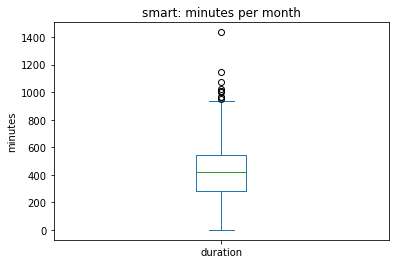

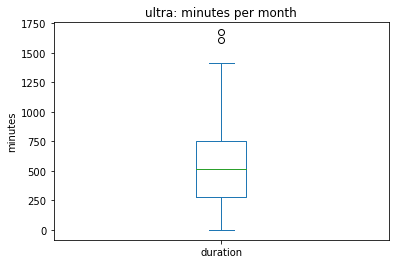

In [18]:
print('mean:\n', monthly.groupby('tariff')['duration'].mean(), '\n\nmedian:\n',
      monthly.groupby('tariff')['duration'].median())
monthly.query('tariff == "smart"')['duration'].plot(kind='box', legend=True, title='smart: minutes per month')
plt.ylabel('minutes')
plt.show()
monthly.query('tariff == "ultra"')['duration'].plot(kind='box', legend=True, title='ultra: minutes per month')
plt.ylabel('minutes')
plt.show()

In [19]:
print('Описание данных группы пользователей с тарифом "smart":')
display(pd.Series(monthly.query('tariff == "smart"')['duration'].describe()).to_frame())
print(f'дисперсия: {np.var(monthly[monthly["tariff"] == "smart"]["duration"])} \n\n',
      'Описание данных группы пользователей с тарифом "ultra":')
display(pd.Series(monthly.query('tariff == "ultra"')['duration'].describe()).to_frame())
print(f'дисперсия: {np.var(monthly[monthly["tariff"] == "ultra"]["duration"])}')

Описание данных группы пользователей с тарифом "smart":


,duration
count,2230.000000
mean,417.747534
std,190.476754
min,0.000000
25%,282.000000
50%,421.500000
75%,545.000000
max,1435.000000


дисперсия: 36265.12415310983 

 Описание данных группы пользователей с тарифом "ultra":


,duration
count,986.000000
mean,526.089249
std,317.887549
min,0.000000
25%,282.500000
50%,518.000000
75%,751.750000
max,1673.000000


дисперсия: 100950.00623331098


Минуты по тарифу: график плотности (с лимитами): 



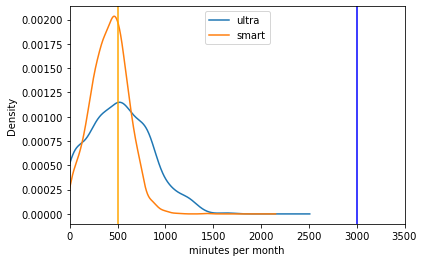

In [20]:
monthly.query('tariff == "ultra"')['duration'].plot(kind='density', legend=True, xlim=(0, 3500))
monthly.query('tariff == "smart"')['duration'].plot(kind='density', legend=True, xlim=(0, 3500))
plt.legend(['ultra', 'smart'])
plt.xlabel('minutes per month')
plt.axvline(x=500, c='orange')
plt.axvline(x=3000, c='blue')
print('Минуты по тарифу: график плотности (с лимитами): \n')
plt.show()

Минуты по тарифу: гистограмм с 10 корзинками (с лимитами): 



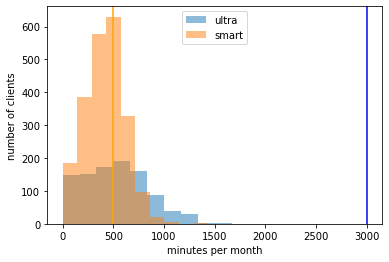

Минуты по тарифу: гистограмм с 25 корзинками (с лимитами): 



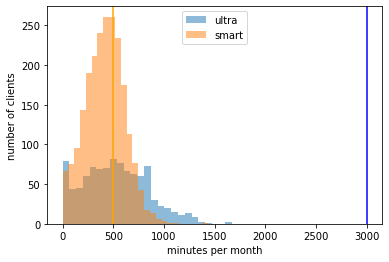

Минуты по тарифу: гистограмм с 50 корзинками (с лимитами): 



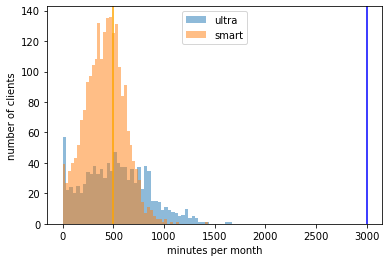

Минуты по тарифу: гистограмм с специальными корзинками (с лимитами): 



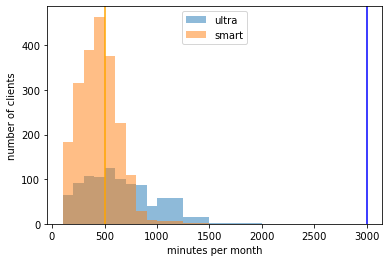

In [21]:
fig, ax = plt.subplots()

monthly.query('tariff == "ultra"')['duration'].plot(kind='hist', bins = 10, legend=True, alpha=0.5, ax=ax)
monthly.query('tariff == "smart"')['duration'].plot(kind='hist', bins = 10, legend=True, alpha=0.5, ax=ax)
plt.legend(['ultra', 'smart'])
plt.xlabel('minutes per month')
plt.ylabel('number of clients')
plt.axvline(x=500, c='orange')
plt.axvline(x=3000, c='blue')
print('Минуты по тарифу: гистограмм с 10 корзинками (с лимитами): \n')
plt.show()

fig, ax1 = plt.subplots()

monthly.query('tariff == "ultra"')['duration'].plot(kind='hist', bins = 25, legend=True, alpha=0.5, ax=ax1)
monthly.query('tariff == "smart"')['duration'].plot(kind='hist', bins = 25, legend=True, alpha=0.5, ax=ax1)
plt.legend(['ultra', 'smart'])
plt.xlabel('minutes per month')
plt.ylabel('number of clients')
plt.axvline(x=500, c='orange')
plt.axvline(x=3000, c='blue')
print('Минуты по тарифу: гистограмм с 25 корзинками (с лимитами): \n')
plt.show()

fig, ax2 = plt.subplots()
monthly.query('tariff == "ultra"')['duration'].plot(kind='hist', bins = 50, legend=True, alpha=0.5, ax=ax2)
monthly.query('tariff == "smart"')['duration'].plot(kind='hist', bins = 50, legend=True, alpha=0.5, ax=ax2)
plt.legend(['ultra', 'smart'])
print('Минуты по тарифу: гистограмм с 50 корзинками (с лимитами): \n')
plt.xlabel('minutes per month')
plt.ylabel('number of clients')
plt.axvline(x=500, c='orange')
plt.axvline(x=3000, c='blue')
plt.show()

fig, ax3 = plt.subplots()
monthly.query('tariff == "ultra"')['duration'].plot(kind='hist',
                                                          bins = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 2000],
                                                          legend=True, alpha=0.5, ax=ax3)
monthly.query('tariff == "smart"')['duration'].plot(kind='hist', 
                                                          bins = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 2000], 
                                                          legend=True, alpha=0.5, ax=ax3)
plt.legend(['ultra', 'smart'])
print('Минуты по тарифу: гистограмм с специальными корзинками (с лимитами): \n')
plt.xlabel('minutes per month')
plt.ylabel('number of clients')
plt.axvline(x=500, c='orange')
plt.axvline(x=3000, c='blue')
plt.show()

Подход к вопросу: "Сколько минут разговора требуется пользователям каждого тарифа в месяц?" :

    - строение следующих графиков:
        - boxplot (ящик с усами)
        - гистограммы
            - с разными количествами корзинок: 10, 25, 50
            - с специально определёнными корзинками
        - график плотности
    - вызов функции .describe для общего описания
        - среди другой информации, выдаёт среднее и стандартное отклонение
    - вызов функции .var (из numpy) чтобы выводнить на экран дисперсию
    
Выводы:

Тариф "Смарт":

Пользователям с этим тарифом требуется в средном 417.75 минут в месяц. Медиана только немного отличается от этого среднего – 421.5 минут. Оба этих значения гораздо меньше чем то число минут, которое включено в тариф.
    
Тариф "Ультра":
    
Пользователям с этим тарифом требуется в средном 526.09 минут в месяц. Медиана только немного отличается от этого среднего – 518 минут. Оба этих значения меньше чем то число минут, которое включено в тариф. К тому же, в наших данных нет единого пользователя с тарифом "Ультра", который превышал лимит минут.

*Сколько сообщений требуется пользователям каждого тарифа в месяц?*
<a id='Сообщения'></a>

tariff
smart    33.369058
ultra    49.313387
Name: messages, dtype: float64


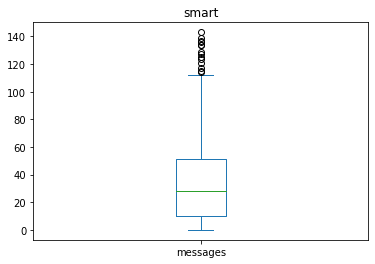

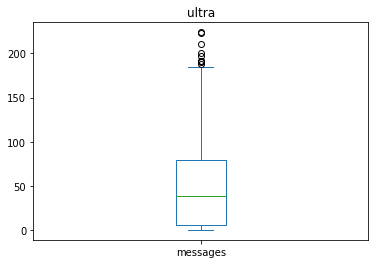

In [22]:
print(monthly.groupby('tariff')['messages'].mean())
monthly.query('tariff == "smart"')['messages'].plot(kind='box', legend=True, title='smart')
plt.show()
monthly.query('tariff == "ultra"')['messages'].plot(kind='box', legend=True, title='ultra')
plt.show()

In [23]:
print('Описание данных группы пользователей с тарифом "smart":')
display(pd.Series(monthly.query('tariff == "smart"')['messages'].describe()).to_frame())
print(f'дисперсия: {np.var(monthly[monthly["tariff"] == "smart"]["messages"])} \n\n',
      'Описание данных группы пользователей с тарифом "ultra":')
display(pd.Series(monthly.query('tariff == "ultra"')['messages'].describe()).to_frame())
print(f'дисперсия: {np.var(monthly[monthly["tariff"] == "ultra"]["messages"])}')

Описание данных группы пользователей с тарифом "smart":


,messages
count,2230.000000
mean,33.369058
std,28.230396
min,0.000000
25%,10.000000
50%,28.000000
75%,51.000000
max,143.000000


дисперсия: 796.5978766916663 

 Описание данных группы пользователей с тарифом "ultra":


,messages
count,986.000000
mean,49.313387
std,47.806040
min,0.000000
25%,6.000000
50%,38.000000
75%,78.750000
max,224.000000


дисперсия: 2283.099557085196


Сообщения по тарифу: график плотности (с лимитами): 



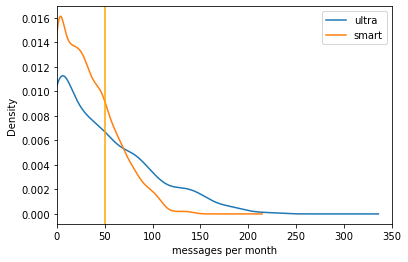

In [24]:
monthly.query('tariff == "ultra"')['messages'].plot(kind='density', legend=True, xlim=(0, 350))
monthly.query('tariff == "smart"')['messages'].plot(kind='density', legend=True, xlim=(0, 350))
plt.legend(['ultra', 'smart'])
plt.xlabel('messages per month')
plt.axvline(x=50, c='orange')
plt.axvline(x=1000, c='blue')
print('Сообщения по тарифу: график плотности (с лимитами): \n')
plt.show()

Сообщения по тарифу: гистограмм с 10 корзинками (с лимитами): 



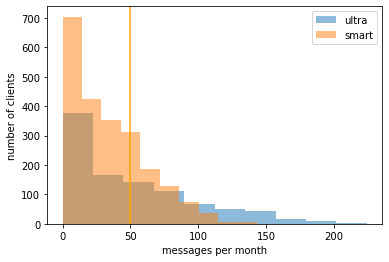

Сообщения по тарифу: гистограмм с 25 корзинками (с лимитами): 



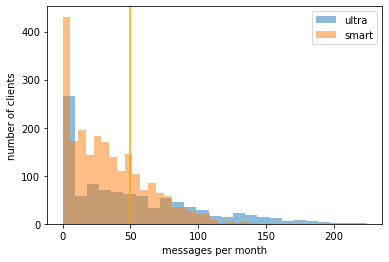

Сообщения по тарифу: гистограмм с 50 корзинками (с лимитами): 



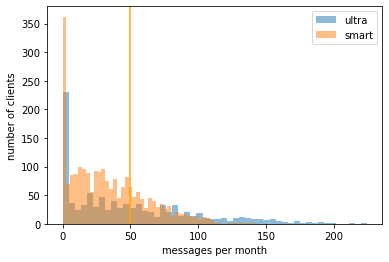

Сообщения по тарифу: гистограмм с специальными корзинками (с лимитами): 



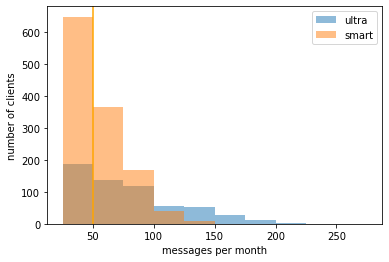

In [25]:
fig, ax = plt.subplots()

monthly.query('tariff == "ultra"')['messages'].plot(kind='hist', bins = 10, legend=True, alpha=0.5, ax=ax)
monthly.query('tariff == "smart"')['messages'].plot(kind='hist', bins = 10, legend=True, alpha=0.5, ax=ax)
plt.legend(['ultra', 'smart'])
plt.xlabel('messages per month')
plt.ylabel('number of clients')
plt.axvline(x=50, c='orange')
# plt.axvline(x=1000, c='blue')
print('Сообщения по тарифу: гистограмм с 10 корзинками (с лимитами): \n')
plt.show()

fig, ax1 = plt.subplots()

monthly.query('tariff == "ultra"')['messages'].plot(kind='hist', bins = 25, legend=True, alpha=0.5, ax=ax1)
monthly.query('tariff == "smart"')['messages'].plot(kind='hist', bins = 25, legend=True, alpha=0.5, ax=ax1)
plt.legend(['ultra', 'smart'])
plt.xlabel('messages per month')
plt.ylabel('number of clients')
plt.axvline(x=50, c='orange')
# plt.axvline(x=1000, c='blue')
print('Сообщения по тарифу: гистограмм с 25 корзинками (с лимитами): \n')
plt.show()

fig, ax2 = plt.subplots()
monthly.query('tariff == "ultra"')['messages'].plot(kind='hist', bins = 50, legend=True, alpha=0.5, ax=ax2)
monthly.query('tariff == "smart"')['messages'].plot(kind='hist', bins = 50, legend=True, alpha=0.5, ax=ax2)
plt.legend(['ultra', 'smart'])
print('Сообщения по тарифу: гистограмм с 50 корзинками (с лимитами): \n')
plt.xlabel('messages per month')
plt.ylabel('number of clients')
plt.axvline(x=50, c='orange')
# plt.axvline(x=1000, c='blue')
plt.show()

fig, ax3 = plt.subplots()
monthly.query('tariff == "ultra"')['messages'].plot(kind='hist',
                                                          bins = [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275],
                                                          legend=True, alpha=0.5, ax=ax3)
monthly.query('tariff == "smart"')['messages'].plot(kind='hist', 
                                                          bins = [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275], 
                                                          legend=True, alpha=0.5, ax=ax3)
plt.legend(['ultra', 'smart'])
print('Сообщения по тарифу: гистограмм с специальными корзинками (с лимитами): \n')
plt.xlabel('messages per month')
plt.ylabel('number of clients')
plt.axvline(x=50, c='orange')
# plt.axvline(x=1000, c='blue')
plt.show()

Подход к вопросу: "Сколько сообщений требуется пользователям каждого тарифа в месяц?" :

    - строение следующих графиков:
        - boxplot (ящик с усами)
        - гистограммы
            - с разными количествами корзинок: 10, 25, 50
            - с специально определёнными корзинками
        - график плотности
    - вызов функции .describe для общего описания
        - среди другой информации, выдаёт среднее и стандартное отклонение
    - вызов функции .var (из numpy) чтобы выводнить на экран дисперсию
    
Выводы:

Тариф "Смарт":

Пользователям с этим тарифом требуется в средном 33.37 сообщений в месяц. Медиана отличается от этого среднего – 28 сообщений. Оба этих значения меньше чем то число сообщений, которое включено в тариф; как правило, пользователи "Смарт" не превышают лимит сообщений в месяц. 
    
Тариф "Ультра":

Пользователям с этим тарифом требуется в средном 49.31 сообщений в месяц. Медиана отличается от этого среднего – 38 сообщений. Оба этих значения меньше чем то число сообщений, которое включено в тариф. В тариф включено 1000 сообщений, и в наших данных нет единого пользователя, который превышал лимит.

*Какой объём интернет-трафики требуется пользователям каждого тарифа в месяц?*
<a id='Объём_интернет_трафики'></a>

tariff
smart    16.321525
ultra    19.474645
Name: gb_used, dtype: float64


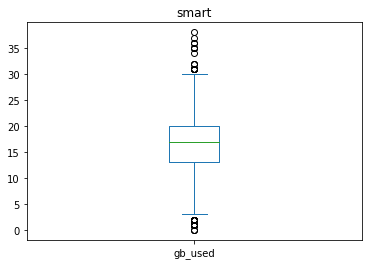

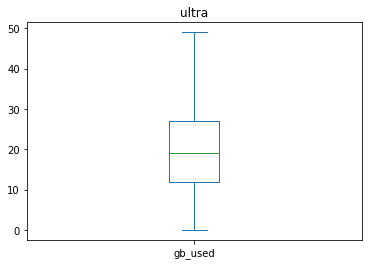

In [26]:
print(monthly.groupby('tariff')['gb_used'].mean())
monthly.query('tariff == "smart"')['gb_used'].plot(kind='box', legend=True, title='smart')
plt.show()
monthly.query('tariff == "ultra"')['gb_used'].plot(kind='box', legend=True, title='ultra')
plt.show()

In [27]:
print('Описание данных группы пользователей с тарифом "smart":')
display(pd.Series(monthly.query('tariff == "smart"')['gb_used'].describe()).to_frame())
print(f'\n дисперсия: {np.var(monthly[monthly["tariff"] == "smart"]["gb_used"])} \n\n',
      'Описание данных группы пользователей с тарифом "ultra":')
display(pd.Series(monthly.query('tariff == "ultra"')['gb_used'].describe()).to_frame())
print(f'\n дисперсия: {np.var(monthly[monthly["tariff"] == "ultra"]["gb_used"])}')

Описание данных группы пользователей с тарифом "smart":


,gb_used
count,2230.000000
mean,16.321525
std,5.756167
min,0.000000
25%,13.000000
50%,17.000000
75%,20.000000
max,38.000000



 дисперсия: 33.1185949848176 

 Описание данных группы пользователей с тарифом "ultra":


,gb_used
count,986.000000
mean,19.474645
std,9.868057
min,0.000000
25%,12.000000
50%,19.000000
75%,27.000000
max,49.000000



 дисперсия: 97.27978308900697


Объём интернет-трафики по тарифу: график плотности (с лимитами): 



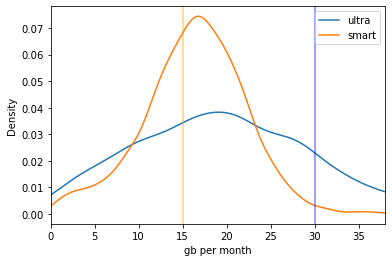

In [28]:
monthly.query('tariff == "ultra"')['gb_used'].plot(kind='density', legend=True, xlim=(0, 38))
monthly.query('tariff == "smart"')['gb_used'].plot(kind='density', legend=True, xlim=(0, 38))
plt.legend(['ultra', 'smart'])
plt.xlabel('gb per month')
plt.axvline(x=15, c='orange', alpha=0.5)
plt.axvline(x=30, c='blue', alpha=0.5)
print('Объём интернет-трафики по тарифу: график плотности (с лимитами): \n')
plt.show()

In [29]:
# display(pd.Series(monthly.query('tariff == "smart"')['gb_used'].describe()).to_frame())
monthly1 = monthly.copy()
monthly1['gb_used'] = [math.ceil(gb) for gb in monthly1['gb_used']]
display(monthly1.query('(tariff == "smart") and (gb_used > 15)'))


,user_id,date,duration,calls,messages,mb_used,gb_used,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,yield
8,1001,11.0,430.0,59.0,0.0,18429.34,18,smart,50,15360,500,550,200,3,3,15.0,1150.0
11,1002,7.0,214.0,26.0,11.0,17580.10,18,smart,50,15360,500,550,200,3,3,15.0,1150.0
12,1002,8.0,289.0,42.0,13.0,20319.26,20,smart,50,15360,500,550,200,3,3,15.0,1550.0
13,1002,9.0,206.0,36.0,4.0,16691.08,17,smart,50,15360,500,550,200,3,3,15.0,950.0
15,1002,11.0,243.0,32.0,16.0,18587.28,19,smart,50,15360,500,550,200,3,3,15.0,1350.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3169,1498,8.0,400.0,57.0,62.0,24235.21,24,smart,50,15360,500,550,200,3,3,15.0,2386.0
3170,1498,9.0,471.0,59.0,44.0,22134.41,22,smart,50,15360,500,550,200,3,3,15.0,1950.0
3171,1498,10.0,247.0,41.0,42.0,20579.36,21,smart,50,15360,500,550,200,3,3,15.0,1750.0
3173,1499,10.0,449.0,68.0,48.0,17788.51,18,smart,50,15360,500,550,200,3,3,15.0,1150.0


Объём интернет-трафики по тарифу: гистограмм с 10 корзинками (с лимитами): 



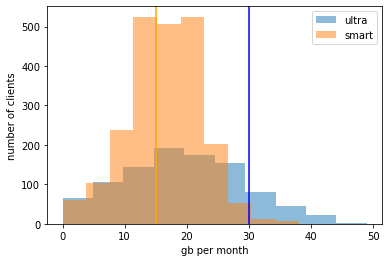

Объём интернет-трафики по тарифу: гистограмм с 25 корзинками (с лимитами): 



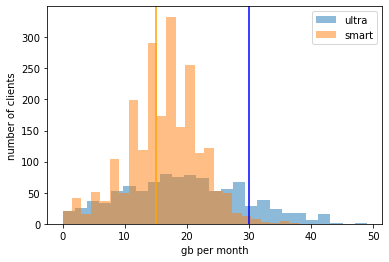

Объём интернет-трафики по тарифу: гистограмм с 50 корзинками (с лимитами): 



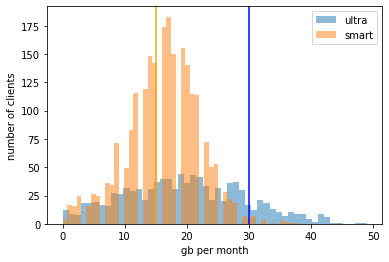

Объём интернет-трафики по тарифу: гистограмм с специальными корзинками (с лимитами): 



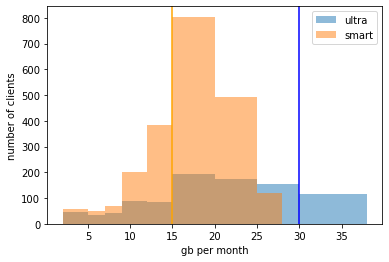

In [30]:
fig, ax = plt.subplots()

monthly.query('tariff == "ultra"')['gb_used'].plot(kind='hist', bins = 10, legend=True, alpha=0.5, ax=ax)
monthly.query('tariff == "smart"')['gb_used'].plot(kind='hist', bins = 10, legend=True, alpha=0.5, ax=ax)
plt.legend(['ultra', 'smart'])
plt.xlabel('gb per month')
plt.ylabel('number of clients')
plt.axvline(x=15, c='orange')
plt.axvline(x=30, c='blue')
print('Объём интернет-трафики по тарифу: гистограмм с 10 корзинками (с лимитами): \n')
plt.show()

fig, ax1 = plt.subplots()

monthly.query('tariff == "ultra"')['gb_used'].plot(kind='hist', bins = 25, legend=True, alpha=0.5, ax=ax1)
monthly.query('tariff == "smart"')['gb_used'].plot(kind='hist', bins = 25, legend=True, alpha=0.5, ax=ax1)
plt.legend(['ultra', 'smart'])
plt.xlabel('gb per month')
plt.ylabel('number of clients')
plt.axvline(x=15, c='orange')
plt.axvline(x=30, c='blue')
print('Объём интернет-трафики по тарифу: гистограмм с 25 корзинками (с лимитами): \n')
plt.show()

fig, ax2 = plt.subplots()
monthly.query('tariff == "ultra"')['gb_used'].plot(kind='hist', bins = 50, legend=True, alpha=0.5, ax=ax2)
monthly.query('tariff == "smart"')['gb_used'].plot(kind='hist', bins = 50, legend=True, alpha=0.5, ax=ax2)
plt.legend(['ultra', 'smart'])
print('Объём интернет-трафики по тарифу: гистограмм с 50 корзинками (с лимитами): \n')
plt.xlabel('gb per month')
plt.ylabel('number of clients')
plt.axvline(x=15, c='orange')
plt.axvline(x=30, c='blue')
plt.show()

fig, ax3 = plt.subplots()
monthly.query('tariff == "ultra"')['gb_used'].plot(kind='hist',
                                                          bins = [2, 5, 7, 9, 12, 15, 20, 25, 30, 38],
                                                          legend=True, alpha=0.5, ax=ax3)
monthly.query('tariff == "smart"')['gb_used'].plot(kind='hist', 
                                                          bins = [2, 5, 7, 9, 12, 15, 20, 25, 28], 
                                                          legend=True, alpha=0.5, ax=ax3)
plt.legend(['ultra', 'smart'])
print('Объём интернет-трафики по тарифу: гистограмм с специальными корзинками (с лимитами): \n')
plt.xlabel('gb per month')
plt.ylabel('number of clients')
plt.axvline(x=15, c='orange')
plt.axvline(x=30, c='blue')
plt.show()

Подход к вопросу: "Какой объём интернет-трафики требуется пользователям каждого тарифа в месяц?" :

    - строение следующих графиков:
        - boxplot (ящик с усами)
        - гистограммы
            - с разными количествами корзинок: 10, 25, 50
            - с специально определёнными корзинками
        - график плотности
    - вызов функции .describe для общего описания
        - среди другой информации, выдаёт среднее и стандартное отклонение
    - вызов функции .var (из numpy) чтобы выводнить на экран дисперсию
    
Выводы:

Тариф "Смарт":

Пользователям с этим тарифом требуется в средном 16.32 гб в месяц. Медиана только чуть-чуть отличается от этого среднего – 17 гб. Оба этих значения чуть выше чем то число гб, которое включено в тариф. В тариф включено 15 гб, так что как правило пользователи превышают лимит гб интернет трафики в месяц на два гб ("Мегалайн" считает 16.32 как 17), или на 400 руб.


Тариф "Ультра":

Пользователям с этим тарифом требуется в средном 19.47 гб в месяц. Медиана только чуть-чуть отличается от этого среднего – 19 гб. Оба этих значения меньше чем то число гб, которое включено в тариф. В тариф включено 30 гб, так что как правило пользователи не первышают лимит гб интернет трафики в месяц.

## Гипотезы и анализ
<a id='Гипотезы_и_анализ'></a>

[Содержание](#Содержание)

### Гипотезы и анализ ###

**Вопрос 1: Различаются ли средняя выручка пользователей тарифов «Ультра» и «Смарт»?**

   
    H0: Средняя выручка пользователей тарифа "Ультра" равна средной выручке пользователей тарифа "Смарт".
    H1: Средняя выручка пользователей тарифа "Смарт" меньше чем средняя выручка пользователей тарифа "Ультра".
    
**Вопрос 2: Отличается ли средняя выручка пользователей из Москвы от выручки пользователей из других регионов?**

   
    H0: Средняя выручка пользователей из Москвы равна средной выручке пользователей из других регионов.
    H1: Средняя выручка пользователей из Москвы больше чем средняя выручки пользователей из других регионов.
   

Создание два переменной чтобы было легче и более читаемо использовать в расчётах.

In [31]:
monthly_smart = monthly[monthly['tariff'] == 'smart']
monthly_ultra = monthly[monthly['tariff'] == 'ultra']

In [32]:
print('Информация по тарифу "Смарт"')
display(monthly_smart.describe().T)
print('\nИнформация по тарифу "Ультра"')
display(monthly_ultra.describe().T)

Информация по тарифу "Смарт"


,count,mean,std,min,25%,50%,75%,max
user_id,2230.0,1246.562332,146.110501,1001.0,1121.000,1240.000,1376.0000,1499.00
date,2230.0,8.343049,2.925006,0.0,6.000,9.000,11.0000,12.00
duration,2230.0,417.747534,190.476754,0.0,282.000,421.500,545.0000,1435.00
calls,2230.0,58.437220,25.963572,0.0,40.000,60.000,76.0000,198.00
messages,2230.0,33.369058,28.230396,0.0,10.000,28.000,51.0000,143.00
mb_used,2230.0,16201.118655,5879.187315,0.0,12630.035,16505.475,20042.1075,38552.45
gb_used,2230.0,16.321525,5.756167,0.0,13.000,17.000,20.0000,38.00
messages_included,2230.0,50.000000,0.000000,50.0,50.000,50.000,50.0000,50.00
mb_per_month_included,2230.0,15360.000000,0.000000,15360.0,15360.000,15360.000,15360.0000,15360.00
minutes_included,2230.0,500.000000,0.000000,500.0,500.000,500.000,500.0000,500.00



Информация по тарифу "Ультра"


,count,mean,std,min,25%,50%,75%,max
user_id,986.0,1262.957404,140.689268,1000.0,1143.000,1277.00,1381.000,1495.00
date,986.0,8.242394,2.882305,0.0,6.000,9.00,11.000,12.00
duration,986.0,526.089249,317.887549,0.0,282.500,518.00,751.750,1673.00
calls,986.0,73.318458,43.956739,0.0,41.000,73.50,103.750,244.00
messages,986.0,49.313387,47.806040,0.0,6.000,38.00,78.750,224.00
mb_used,986.0,19449.059970,10101.095459,0.0,11748.585,19304.02,26835.885,49745.69
gb_used,986.0,19.474645,9.868057,0.0,12.000,19.00,27.000,49.00
messages_included,986.0,1000.000000,0.000000,1000.0,1000.000,1000.00,1000.000,1000.00
mb_per_month_included,986.0,30720.000000,0.000000,30720.0,30720.000,30720.00,30720.000,30720.00
minutes_included,986.0,3000.000000,0.000000,3000.0,3000.000,3000.00,3000.000,3000.00


**Вопрос 1: Различаются ли средняя выручка пользователей тарифов «Ультра» и «Смарт»?**

    H0: Средняя выручка пользователей тарифа "Ультра" равна средной выручке пользователей тарифа "Смарт".
    H1: Средняя выручка пользователей тарифа "Смарт" не равна средной выручке пользователей тарифа "Ультра".

In [33]:
alpha_yield = 0.05
results_yield = st.ttest_ind(monthly_smart['yield'], monthly_ultra['yield'], equal_var=False)

print('p-значение: ', results_yield.pvalue)

if results_yield.pvalue < alpha_yield:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  1.927011394420941e-250
Отвергаем нулевую гипотезу


**Вопрос 1: Различаются ли средняя выручка пользователей тарифов «Ультра» и «Смарт»?**

H0 отвергнута. 

In [34]:
alpha_1side = 0.05
results_1side = st.ttest_ind(monthly_smart['yield'], monthly_ultra['yield'], equal_var=False)

print('p-значение:', results_1side.pvalue / 2)

if (results_1side.pvalue / 2 < alpha_1side) and (monthly_smart['yield'].mean() < monthly_ultra['yield'].mean()):
    print("\nОтвергаем альтернативную гипотезу H1: \nСредняя выручка пользователей тарифа 'Смарт' не меньше чем средняя выручка пользователей тарифа 'Ультра'.")
else:
    print("\nНе отвергаем альтернативную гипотезу H1: \nСредняя выручка пользователей тарифа 'Смарт' меньше чем средняя выручка пользователей тарифа 'Ультра'.") 


p-значение: 9.635056972104705e-251

Не отвергаем альтернативную гипотезу H1: 
Средняя выручка пользователей тарифа 'Смарт' меньше чем средняя выручка пользователей тарифа 'Ультра'.


In [ ]:
print('Описание данных о выручке пользователей с тарифом "Смарт":')
display(pd.Series(monthly_smart['yield'].describe()).to_frame())
print('\nОписание данных о выручке пользователей с тарифом "Ультра":')
display(pd.Series(monthly_ultra['yield'].describe()).to_frame())


***Вопрос 1: Различаются ли средняя выручка пользователей тарифов «Ультра» и «Смарт»?***

    H0: Средняя выручка пользователей тарифа "Ультра" равна средной выручке пользователей тарифа "Смарт".
    H1: Средняя выручка пользователей тарифа "Смарт" меньше чем средняя выручка пользователей тарифа "Ультра".
    
Нулевая гипотеза отвергается. Альтернативная гипотеза не отвергается.

С помощью заданного мною порога (alpha) p-значения, я заключил, что:

*Средняя выручка пользователей тарифа "Смарт" меньше чем средняя выручка пользователей тарифа "Ультра".*

Насчёт выбранного значения alpha:

Я решил пользоваться alpha по выше (0.10) из-за маленького количества данных. То есть, alpha 0.05 бы означало, что проверяю то, что с вероятностью 5% или меньше случайные данные будут за пределами (приблизительно) двух стандартных отклонений от среднего. Поскольку расследую данные всего 500 пользователей, мне кажется, что результаты от такой проверки будут не настолько значимы.

В такой маленькой совокупности данных, отдельные пользователи, которые возможно были бы исключениями/выбросами в более объёмной совокупности данных, могут влиять на среднее. 

Однако, посмотрив описания данных о выручке для обеих групп, я понял, что данные настолько отличаются друг от друга, что можно было бы задать alpha гораздо жёстчего значения (например 0.0001), и результаты бы не изменились (ни для проверки H0, ни для проверки H1).

Я всё-таки считаю, что количество данных слишком мало чтобы делать достоверные выводы, но хотя бы для вопроса о выручке того или иного тарифа, данные показывают, что бОльшая выручка получается от пользователей с тарифом "Смарт".





**Вопрос 2: Отличается ли средняя выручка пользователей из Москвы от выручки пользователей из других регионов?**

    H0: Средняя выручка пользователей из Москвы равна средной выручке пользователей из других регионов.
    H1: Средняя выручка пользователей из Москвы больше чем средняя выручки пользователей из других регионов.

Создадим новые таблицы для сравнения и анализа.

In [36]:
monthly_cities = monthly.merge(users[['city', 'user_id']], how='outer', on='user_id')
monthly_moscow = monthly_cities[monthly_cities['city'] == 'Москва']
monthly_non_moscow = monthly_cities[monthly_cities['city'] != 'Москва']
display(monthly_cities.head(), monthly_moscow.head(), monthly_non_moscow.head())

,user_id,date,duration,calls,messages,mb_used,gb_used,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,yield,city
0,1000,5.0,159.0,22.0,22.0,2253.49,3.0,ultra,1000,30720,3000,1950,150,1,1,30.0,1950.0,Краснодар
1,1000,6.0,172.0,43.0,60.0,23233.77,23.0,ultra,1000,30720,3000,1950,150,1,1,30.0,1950.0,Краснодар
2,1000,7.0,340.0,47.0,75.0,14003.64,14.0,ultra,1000,30720,3000,1950,150,1,1,30.0,1950.0,Краснодар
3,1000,8.0,408.0,52.0,81.0,14055.93,14.0,ultra,1000,30720,3000,1950,150,1,1,30.0,1950.0,Краснодар
4,1000,9.0,466.0,58.0,57.0,14568.91,15.0,ultra,1000,30720,3000,1950,150,1,1,30.0,1950.0,Краснодар


,user_id,date,duration,calls,messages,mb_used,gb_used,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,yield,city
8,1001,11.0,430.0,59.0,0.0,18429.34,18.0,smart,50,15360,500,550,200,3,3,15.0,1150.0,Москва
9,1001,12.0,414.0,63.0,0.0,14036.66,14.0,smart,50,15360,500,550,200,3,3,15.0,550.0,Москва
17,1003,8.0,380.0,55.0,37.0,8565.21,9.0,ultra,1000,30720,3000,1950,150,1,1,30.0,1950.0,Москва
18,1003,9.0,961.0,134.0,91.0,12468.87,13.0,ultra,1000,30720,3000,1950,150,1,1,30.0,1950.0,Москва
19,1003,10.0,855.0,108.0,83.0,14768.14,15.0,ultra,1000,30720,3000,1950,150,1,1,30.0,1950.0,Москва


,user_id,date,duration,calls,messages,mb_used,gb_used,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,yield,city
0,1000,5.0,159.0,22.0,22.0,2253.49,3.0,ultra,1000,30720,3000,1950,150,1,1,30.0,1950.0,Краснодар
1,1000,6.0,172.0,43.0,60.0,23233.77,23.0,ultra,1000,30720,3000,1950,150,1,1,30.0,1950.0,Краснодар
2,1000,7.0,340.0,47.0,75.0,14003.64,14.0,ultra,1000,30720,3000,1950,150,1,1,30.0,1950.0,Краснодар
3,1000,8.0,408.0,52.0,81.0,14055.93,14.0,ultra,1000,30720,3000,1950,150,1,1,30.0,1950.0,Краснодар
4,1000,9.0,466.0,58.0,57.0,14568.91,15.0,ultra,1000,30720,3000,1950,150,1,1,30.0,1950.0,Краснодар


In [37]:
alpha_cities = 0.05
results_cities = st.ttest_ind(monthly_moscow['yield'], monthly_non_moscow['yield'], equal_var=False)

print('p-значение: ', results_cities.pvalue)

if (results_cities.pvalue/2 < alpha_cities) and (monthly_moscow['yield'].mean() > monthly_non_moscow['yield'].mean()):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.5216952110000278
Не получилось отвергнуть нулевую гипотезу


In [38]:
print('Описание данных о выручке пользователей в Москве:')
display(pd.Series(monthly_moscow['yield'].describe()).to_frame())
print('\n\nОписание данных о выручке пользователей вне Москвы:')
display(pd.Series(monthly_non_moscow['yield'].describe()).to_frame())



Описание данных о выручке пользователей в Москве:


,yield
count,611.000000
mean,1546.713584
std,752.088071
min,550.000000
25%,780.500000
50%,1750.000000
75%,1950.000000
max,5321.000000




Описание данных о выручке пользователей вне Москвы:


,yield
count,2605.000000
mean,1524.725144
std,808.745680
min,550.000000
25%,750.000000
50%,1583.000000
75%,1950.000000
max,6770.000000


***Вопрос 2: Отличается ли средняя выручка пользователей из Москвы от выручки пользователей из других регионов?***

    H0: Средняя выручка пользователей из Москвы равна средной выручке пользователей из других регионов.
    H1: Средняя выручка пользователей из Москвы больше чем средняя выручки пользователей из других регионов.


Нулевая гипотеза не отвергается – С помощью заданного мною порога (alpha) p-значения, я заключил, что:

*Средняя выручка пользователей из Москвы равна средной выручке пользователей из других регионов.*

Я решил пользоваться alpha по выше (0.10) из-за маленького количества данных. То есть, alpha 0.05 бы означало, что проверяю то, что с вероятностью 5% или меньше случайные данные будут за пределами (приблизительно) двух стандартных отклонений от среднего. Поскольку расследую данные всего 500 пользователей, мне кажется, что результаты от такой проверки будут не настолько значимы.

В такой маленькой совокупности данных, отдельные пользователи, которые возможно были бы исключениями/выбросами в более объёмной совокупности данных, могут влиять на среднее.

Например, хотя среднее для пользователей вне Москвы 4450 руб/мес, максимальная выручка от пользователя в этой группе 25825 руб/мес, а даже стандартное отклонение, 5190.21, превышает среднее. Иными словами, здесь есть сравнительно большой разброс по отношению к количеству пользователей. Даже с выбранным мною alpha, 10% (0.10), я бы не доверял такому анализу. Нужно больше данных.

## Общие Выводы
<a id='Общие_Выводы'></a>

**Вывод 1:**
    
С точки зрения "Мегалайна", тариф "Ультра" выгоднее. Хотя только очень редкие пользователи превышают лимиты тарифа по сообщениям/минутам/гб, ежемесячная плата за тариф 1950 рублей, которое уже больше чем плата (с доплатой за превышение лимитов включено) поддавляющего большинства пользователей с тарифом "Смарт".
    

**Вывод 2:**

"Мегалайн" получает похожую выручку от пользователей в Москве, как и от пользователей в других регионах. Данные в нашем распоряжении не отвергли такой вывод.


*Коментарий:*

Мне кажется, что для хорошего анализа, тут не хватает данных. Совокупность составляется от информации о всего 500 пользователей. К тому же, только у 99 из этих пользователей есть тариф "Ультра". Кажется, что для достоверного приведения выводов, это не достаточно. Сеть "Мегалайн" работает в (как минимум) 76 городах - это количество уникальных значений в столбце 'city' в таблице users. Это значит, что сеть довольно общирная, а поэтому считаю, что анализ информации о 500 пользователей недостаточно для хорошего, значительного анализа.

[Содержание](#Содержание)